In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
from sklearn.metrics import multilabel_confusion_matrix
from numpy import savetxt
import sklearn.metrics as metric

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_path = 'gdrive/My Drive/MS-ITU-Smester-02/DL-05-part2/A_05_Part_02_Dataset'

### Loading and normalizing CIFAR10

In [7]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(root_path + '/Train', transform=train_transforms)
test_data = datasets.ImageFolder(root_path + '/Test', transform=test_transforms)
validation_data = datasets.ImageFolder(root_path + '/Validation', transform=test_transforms)
#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True,num_workers=6)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True,num_workers=6)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True,num_workers=6)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


In [0]:
wholeDataLoader = {'train':trainloader, 'val':validationloader} # for training and validation

#### Training Model


In [0]:
#if you have gpu then you need to convert the network and data to cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
class focal_loss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(focal_loss,self).__init__()
        self.a = alpha
        self.g = gamma
        
    def forward(self, outputs, labels):
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')(outputs, labels)
        pt = torch.exp(-bce_loss)
        loss = self.a * ((1-pt)**self.g) * bce_loss
        return loss.mean()


In [0]:
 def plotGraph(epochs, TrainData,validationData, yLabel):
    plt.figure(figsize= (7,7) )  
    plt.plot(np.arange(epochs), TrainData)
    plt.plot(np.arange(epochs), validationData)
    plt.legend(["Training " +yLabel ,"Validation " + yLabel])
    plt.xlabel("Number of Epochs")
    plt.ylabel(yLabel)

In [0]:
def getPrediction(model,dataLoader):
  model.to(device)
  correct = 0
  total = 0
  actual = np.array([0,0,0]) 
  preds = np.array([0,0,0])
  with torch.no_grad():
      for data in dataLoader:
          images, labels = data
          labels = torch.nn.functional.one_hot(labels, 3)
          labels = labels.float()
          actual = np.vstack(( actual, np.array(labels.to('cpu')) ))
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          pred = torch.sigmoid(outputs.data)
          pred[pred>=0.5] = 1
          pred[pred<0.5]  = 0
          preds = np.vstack(( preds, np.array(pred.to('cpu')) ))

  preds = np.delete(preds, 0, 0) 
  actual = np.delete(actual, 0, 0)  
  return actual, preds

In [0]:
def testAccuracy(model,testloader):
  model.to(device)
  correct = 0
  total = 0
  preds = np.array([0,0,0])
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          labels = torch.nn.functional.one_hot(labels, 3)
          labels = labels.float()

          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          pred = torch.sigmoid(outputs.data)
          pred[pred>=0.5] = 1
          pred[pred<0.5]  = 0
          preds = np.vstack(( preds, np.array(pred.to('cpu')) ))
  preds = np.delete(preds, 0, 0)  
  return preds

In [0]:
def printConfusionMatrix(classNames, f1Scores, confusionMatrix):
  for i,className in enumerate(classNames):
    print('F1 score for {} = {:.4f}'.format(className, f1Scores[i]))
    print('Confusion matrix:')
    print(confusionMatrix[i],'\n')


In [0]:
def displayMeasures(actual, preds):
  total = len(actual)
  #Calculating Accuracy
  correct = (preds == actual).prod(1).sum().item()
  print('Accuracy of the network on the training images: %d %%' % (
      100 * correct / total))

  #Calculating Confusion Matrix:
  confusionMatrix = multilabel_confusion_matrix(actual, preds)

  #Calculating F1 Score
  f1Score = metric.f1_score(actual, preds, average=None)
  printConfusionMatrix(class_names, f1Score, confusionMatrix)


In [0]:
def train_model(model, criterion, optimizer, num_epochs=10):
    start = time.time()

    trainErr = []
    trainAcc = []
    validErr = []
    validAcc = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            total = 0

            # Iterate over data.
            for inputs, labels in wholeDataLoader[phase]:
                labels = torch.nn.functional.one_hot(labels, 3)
                labels = labels.float()
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    pred = torch.sigmoid(outputs.data)
                    pred[pred>=0.5] = 1
                    pred[pred<0.5]  = 0

                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

              
                running_loss += loss.item() * inputs.size(0)
                total += labels.size(0)
                running_corrects += (pred == labels).prod(1).sum().item()
            
            epoch_loss = running_loss / total
            epoch_acc  = running_corrects / total

            print('Epoch {}/{},{} ==> Loss: {:.4f} , Acc: {:.2f} %'.format(
                epoch+1, num_epochs,phase, epoch_loss, epoch_acc*100))
            
            
            if phase == 'train':
                trainErr.append(epoch_loss)
                trainAcc.append(epoch_acc*100)
            else:
                validErr.append(epoch_loss)
                validAcc.append(epoch_acc*100)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    endtime = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format( endtime // 60, endtime % 60))
    print('Best Validation Accuracy: {:4f} %'.format(best_acc*100))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, trainErr, validErr,trainAcc, validAcc

### Training and Validation Without Focal Loss 

#### VGG-16


In [117]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# Making Custom Classifier
new_layers = []
new_layers.extend( [nn.Linear( vgg16.classifier[0].in_features , 4096)])
new_layers.extend( [nn.ReLU( inplace=True )])
new_layers.extend( [nn.Dropout( p=0.5, inplace=False )])
new_layers.extend( [nn.Linear( 4096 , len(class_names) )])

# Modifying new layers in VGG16 architecture
vgg16.classifier = nn.Sequential(*new_layers)

In [0]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
vgg16 = vgg16.to(device)

In [14]:
##### training
#vgg16Model,trainingError,validationError,trainingAccurcy,validationAccuracy = train_model( vgg16, criterion, optimizer, Epochs )

Epoch 1/10,train ==> Loss: 0.1932 , Acc: 68.98 %
Epoch 1/10,val ==> Loss: 0.1247 , Acc: 85.35 %
Epoch 2/10,train ==> Loss: 0.1439 , Acc: 80.26 %
Epoch 2/10,val ==> Loss: 0.1082 , Acc: 89.01 %
Epoch 3/10,train ==> Loss: 0.1273 , Acc: 82.73 %
Epoch 3/10,val ==> Loss: 0.1027 , Acc: 89.01 %
Epoch 4/10,train ==> Loss: 0.1166 , Acc: 84.03 %
Epoch 4/10,val ==> Loss: 0.0957 , Acc: 89.01 %
Epoch 5/10,train ==> Loss: 0.1168 , Acc: 84.27 %
Epoch 5/10,val ==> Loss: 0.0878 , Acc: 88.85 %
Epoch 6/10,train ==> Loss: 0.1081 , Acc: 85.55 %
Epoch 6/10,val ==> Loss: 0.0861 , Acc: 89.01 %
Epoch 7/10,train ==> Loss: 0.1080 , Acc: 85.06 %
Epoch 7/10,val ==> Loss: 0.0969 , Acc: 86.78 %
Epoch 8/10,train ==> Loss: 0.1016 , Acc: 86.26 %
Epoch 8/10,val ==> Loss: 0.0807 , Acc: 90.13 %
Epoch 9/10,train ==> Loss: 0.1023 , Acc: 86.05 %
Epoch 9/10,val ==> Loss: 0.0803 , Acc: 90.45 %
Epoch 10/10,train ==> Loss: 0.1004 , Acc: 85.73 %
Epoch 10/10,val ==> Loss: 0.0988 , Acc: 89.01 %
Training complete in 32m 47s
Best Vali

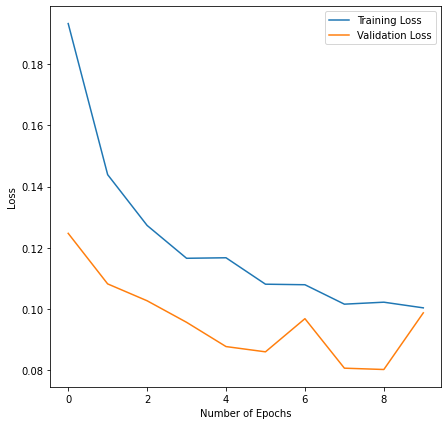

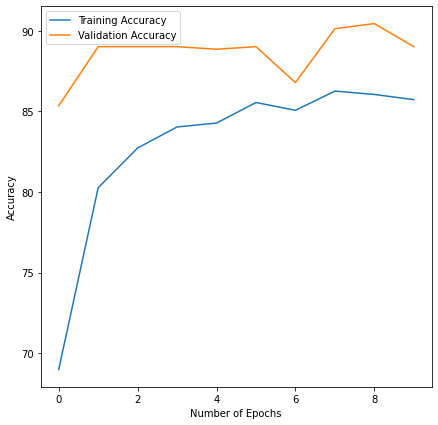

In [15]:
#plotGraph(Epochs,trainingError,validationError, "Loss")
#plotGraph(Epochs,trainingAccurcy,validationAccuracy, "Accuracy")

In [0]:
#torch.save(vgg16Model.state_dict(), 'gdrive/My Drive/MS-ITU-Smester-02/DL-05-part2/vgg16_without_focal_loss.pth')

##### Loading PreTRained Model

In [120]:
vgg16.load_state_dict(torch.load('gdrive/My Drive/MS-ITU-Smester-02/DL-05-part2/vgg16_without_focal_loss.pth'))

<All keys matched successfully>

##### Training Accuracy and Confusion Matrix

In [121]:
actual , preds = getPrediction(vgg16,trainloader )
displayMeasures(actual , preds)

Accuracy of the network on the training images: 87 %
F1 score for covid-19 = 0.2212
Confusion matrix:
[[5999    1]
 [ 175   25]] 

F1 score for normal = 0.9316
Confusion matrix:
[[1795  405]
 [ 159 3841]] 

F1 score for pneumonia = 0.8404
Confusion matrix:
[[3944  256]
 [ 365 1635]] 



##### Validation Accuracy And Confusion Matrix

In [122]:
actual , preds = getPrediction(vgg16,validationloader )
displayMeasures(actual , preds)

Accuracy of the network on the training images: 90 %
F1 score for covid-19 = 0.3529
Confusion matrix:
[[600   0]
 [ 22   6]] 

F1 score for normal = 0.9502
Confusion matrix:
[[196  32]
 [  9 391]] 

F1 score for pneumonia = 0.9040
Confusion matrix:
[[411  17]
 [ 21 179]] 



##### Testing Data CSV File Write For VGG -16

In [0]:
### Testing Images Names : To append in the output file
image_names = []
for file in os.listdir(root_path+"/Test/unlabelled"):
    image_names.append(file)
image_names = np.array(image_names).reshape(len(image_names),1)

In [0]:
preds = testAccuracy(vgg16,testloader)
preds = np.hstack((image_names, preds))

In [0]:
savetxt('gdrive/My Drive/MS-ITU-Smester-02/DL-05-part2/vgg16_woFocalLocal_output.csv', preds, delimiter=',',fmt='%s')

#### Resnet-18

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)

In [0]:
# Making Custom Classifier
new_layers = []
new_layers.extend( [nn.Linear(512 , len(class_names) )])

# Modifying new layers in VGG16 architecture
resnet18.fc = nn.Sequential(*new_layers)

In [0]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
resnet18 = resnet18.to(device)

In [42]:
##### training
#resnetModel,trainingError,validationError,trainingAccurcy,validationAccuracy = train_model( resnet18, criterion, optimizer, Epochs )

Epoch 1/10,train ==> Loss: 0.2033 , Acc: 64.74 %
Epoch 1/10,val ==> Loss: 0.1447 , Acc: 81.85 %
Epoch 2/10,train ==> Loss: 0.1447 , Acc: 79.77 %
Epoch 2/10,val ==> Loss: 0.1250 , Acc: 83.60 %
Epoch 3/10,train ==> Loss: 0.1298 , Acc: 82.08 %
Epoch 3/10,val ==> Loss: 0.1197 , Acc: 84.87 %
Epoch 4/10,train ==> Loss: 0.1236 , Acc: 82.77 %
Epoch 4/10,val ==> Loss: 0.1078 , Acc: 86.78 %
Epoch 5/10,train ==> Loss: 0.1179 , Acc: 82.97 %
Epoch 5/10,val ==> Loss: 0.1086 , Acc: 86.46 %
Epoch 6/10,train ==> Loss: 0.1138 , Acc: 84.32 %
Epoch 6/10,val ==> Loss: 0.1006 , Acc: 86.94 %
Epoch 7/10,train ==> Loss: 0.1113 , Acc: 84.53 %
Epoch 7/10,val ==> Loss: 0.0941 , Acc: 87.42 %
Epoch 8/10,train ==> Loss: 0.1068 , Acc: 85.24 %
Epoch 8/10,val ==> Loss: 0.0895 , Acc: 89.17 %
Epoch 9/10,train ==> Loss: 0.1054 , Acc: 85.13 %
Epoch 9/10,val ==> Loss: 0.0881 , Acc: 88.85 %
Epoch 10/10,train ==> Loss: 0.1026 , Acc: 85.95 %
Epoch 10/10,val ==> Loss: 0.0839 , Acc: 89.17 %
Training complete in 24m 14s
Best Vali

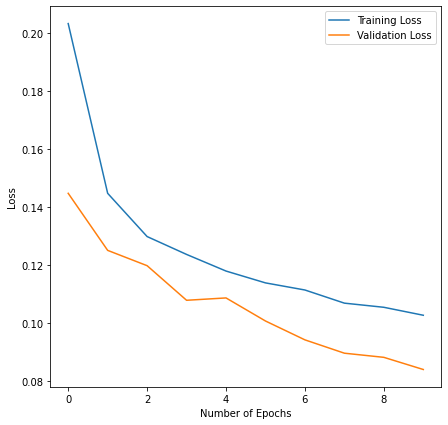

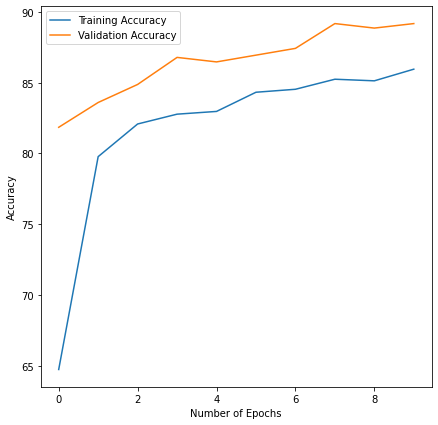

In [43]:
#plotGraph(Epochs,trainingError,validationError, "Loss")
#plotGraph(Epochs,trainingAccurcy,validationAccuracy, "Accuracy")

In [0]:
#torch.save(resnetModel.state_dict(), 'gdrive/My Drive/MS-ITU-Smester-02/DL-05-part2/res18_without_focal_loss.pth')

In [126]:
resnet18.load_state_dict(torch.load('gdrive/My Drive/MS-ITU-Smester-02/DL-05-part2/res18_without_focal_loss.pth'))

<All keys matched successfully>

##### Training Accuracy and Confusion Matrix

In [127]:
actual , preds = getPrediction(resnet18,trainloader )
displayMeasures(actual , preds)

Accuracy of the network on the training images: 85 %
F1 score for covid-19 = 0.2035
Confusion matrix:
[[5997    3]
 [ 177   23]] 

F1 score for normal = 0.9219
Confusion matrix:
[[1837  363]
 [ 269 3731]] 

F1 score for pneumonia = 0.8241
Confusion matrix:
[[3907  293]
 [ 393 1607]] 



##### Validation Accuracy And Confusion Matrix

In [128]:
actual , preds = getPrediction(resnet18,validationloader )
displayMeasures(actual , preds)

Accuracy of the network on the training images: 87 %
F1 score for covid-19 = 0.1935
Confusion matrix:
[[600   0]
 [ 25   3]] 

F1 score for normal = 0.9271
Confusion matrix:
[[194  34]
 [ 25 375]] 

F1 score for pneumonia = 0.8744
Confusion matrix:
[[404  24]
 [ 26 174]] 



##### Testing Data CSV File Write For resnet18

In [0]:
preds = testAccuracy(resnet18,testloader)
preds = np.hstack((image_names, preds))

In [0]:
savetxt('gdrive/My Drive/MS-ITU-Smester-02/DL-05-part2/resnet18_woFocalLocal_output.csv', preds, delimiter=',',fmt='%s')

### Training and Validation With Focal Loss


#### VGG 16

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

In [0]:
# Making Custom Classifier
new_layers = []
new_layers.extend( [nn.Linear( vgg16.classifier[0].in_features , 4096)])
new_layers.extend( [nn.ReLU( inplace=True )])
new_layers.extend( [nn.Dropout( p=0.5, inplace=False )])
new_layers.extend( [nn.Linear( 4096 , len(class_names) )])

# Modifying new layers in VGG16 architecture
vgg16.classifier = nn.Sequential(*new_layers)

In [0]:
Epochs = 10
criterion = focal_loss(alpha=1, gamma=2)
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
vgg16 = vgg16.to(device)

In [48]:
##### training ,
vgg16ModelFocalLoss,trainingError,validationError,trainingAccurcy,validationAccuracy = train_model( vgg16, criterion, optimizer, Epochs )

Epoch 1/10,train ==> Loss: 0.1949 , Acc: 69.02 %
Epoch 1/10,val ==> Loss: 0.1216 , Acc: 85.99 %
Epoch 2/10,train ==> Loss: 0.1367 , Acc: 81.66 %
Epoch 2/10,val ==> Loss: 0.1004 , Acc: 89.49 %
Epoch 3/10,train ==> Loss: 0.1224 , Acc: 83.82 %
Epoch 3/10,val ==> Loss: 0.0977 , Acc: 89.65 %
Epoch 4/10,train ==> Loss: 0.1173 , Acc: 84.23 %
Epoch 4/10,val ==> Loss: 0.0942 , Acc: 90.29 %
Epoch 5/10,train ==> Loss: 0.1130 , Acc: 84.68 %
Epoch 5/10,val ==> Loss: 0.1044 , Acc: 86.62 %
Epoch 6/10,train ==> Loss: 0.1123 , Acc: 84.69 %
Epoch 6/10,val ==> Loss: 0.0854 , Acc: 90.45 %
Epoch 7/10,train ==> Loss: 0.1045 , Acc: 85.90 %
Epoch 7/10,val ==> Loss: 0.0857 , Acc: 90.13 %
Epoch 8/10,train ==> Loss: 0.1015 , Acc: 86.24 %
Epoch 8/10,val ==> Loss: 0.0885 , Acc: 89.49 %
Epoch 9/10,train ==> Loss: 0.1014 , Acc: 86.42 %
Epoch 9/10,val ==> Loss: 0.0810 , Acc: 91.24 %
Epoch 10/10,train ==> Loss: 0.1009 , Acc: 86.16 %
Epoch 10/10,val ==> Loss: 0.0800 , Acc: 91.08 %
Training complete in 33m 50s
Best Vali

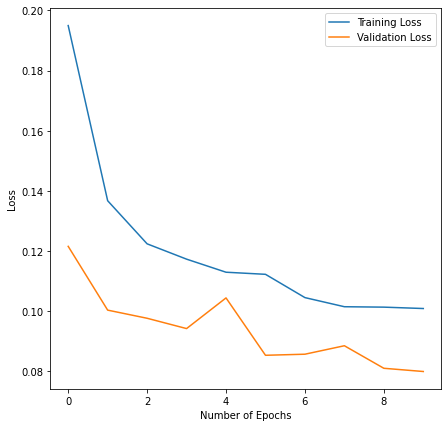

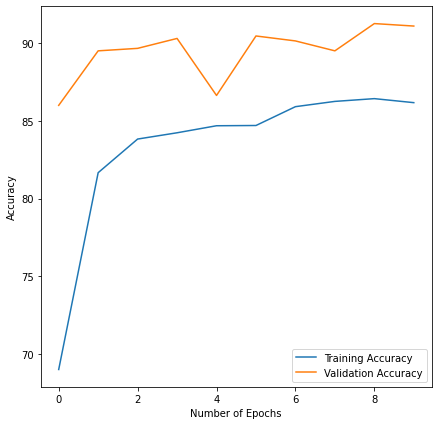

In [49]:
plotGraph(Epochs,trainingError,validationError, "Loss")
plotGraph(Epochs,trainingAccurcy,validationAccuracy, "Accuracy")

In [0]:
torch.save(vgg16ModelFocalLoss.state_dict(), 'gdrive/My Drive/MS-ITU-Smester-02/DL-05-part2/vgg16_focal_loss.pth')

In [84]:
vgg16.load_state_dict(torch.load('gdrive/My Drive/MS-ITU-Smester-02/DL-05-part2/vgg16_focal_loss.pth'))

<All keys matched successfully>

##### Training Accuracy and Confusion Matrix

In [115]:
actual , preds = getPrediction(vgg16,trainloader )
displayMeasures(actual , preds)

Accuracy of the network on the training images: 86 %
F1 score for covid-19 = 0.2203
Confusion matrix:
[[5998    2]
 [ 175   25]] 

F1 score for normal = 0.9313
Confusion matrix:
[[1788  412]
 [ 155 3845]] 

F1 score for pneumonia = 0.8394
Confusion matrix:
[[3934  266]
 [ 361 1639]] 



##### Validation Accuracy And Confusion Matrix

In [116]:
actual , preds = getPrediction(vgg16,validationloader )
displayMeasures(actual , preds)

Accuracy of the network on the training images: 91 %
F1 score for covid-19 = 0.3030
Confusion matrix:
[[600   0]
 [ 23   5]] 

F1 score for normal = 0.9526
Confusion matrix:
[[197  31]
 [  8 392]] 

F1 score for pneumonia = 0.9192
Confusion matrix:
[[414  14]
 [ 18 182]] 



##### Testing Data CSV File Write For vgg16

In [0]:
preds = testAccuracy(vgg16,testloader)
preds = np.hstack((image_names, preds))

In [0]:
savetxt('gdrive/My Drive/MS-ITU-Smester-02/DL-05-part2/vgg16_FocalLocal_output.csv', preds, delimiter=',',fmt='%s')

#### resnet18 

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)

In [0]:
# Making Custom Classifier
new_layers = []
new_layers.extend( [nn.Linear(512 , len(class_names) )])

# Modifying new layers in VGG16 architecture
resnet18.fc = nn.Sequential(*new_layers)

In [0]:
Epochs = 10
criterion = focal_loss(alpha=1, gamma=2)
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
resnet18 = resnet18.to(device)

In [56]:
##### training
resnetModelFocalLoss,trainingError,validationError,trainingAccurcy,validationAccuracy = train_model( resnet18, criterion, optimizer, Epochs )

Epoch 1/10,train ==> Loss: 0.1114 , Acc: 59.76 %
Epoch 1/10,val ==> Loss: 0.0833 , Acc: 79.14 %
Epoch 2/10,train ==> Loss: 0.0820 , Acc: 75.53 %
Epoch 2/10,val ==> Loss: 0.0695 , Acc: 83.28 %
Epoch 3/10,train ==> Loss: 0.0728 , Acc: 79.79 %
Epoch 3/10,val ==> Loss: 0.0631 , Acc: 84.39 %
Epoch 4/10,train ==> Loss: 0.0688 , Acc: 80.97 %
Epoch 4/10,val ==> Loss: 0.0616 , Acc: 85.51 %
Epoch 5/10,train ==> Loss: 0.0652 , Acc: 81.66 %
Epoch 5/10,val ==> Loss: 0.0583 , Acc: 85.99 %
Epoch 6/10,train ==> Loss: 0.0637 , Acc: 82.27 %
Epoch 6/10,val ==> Loss: 0.0554 , Acc: 86.46 %
Epoch 7/10,train ==> Loss: 0.0618 , Acc: 82.81 %
Epoch 7/10,val ==> Loss: 0.0531 , Acc: 86.15 %
Epoch 8/10,train ==> Loss: 0.0597 , Acc: 83.84 %
Epoch 8/10,val ==> Loss: 0.0528 , Acc: 85.67 %
Epoch 9/10,train ==> Loss: 0.0612 , Acc: 83.53 %
Epoch 9/10,val ==> Loss: 0.0515 , Acc: 87.10 %
Epoch 10/10,train ==> Loss: 0.0584 , Acc: 84.32 %
Epoch 10/10,val ==> Loss: 0.0501 , Acc: 87.42 %
Training complete in 24m 24s
Best Vali

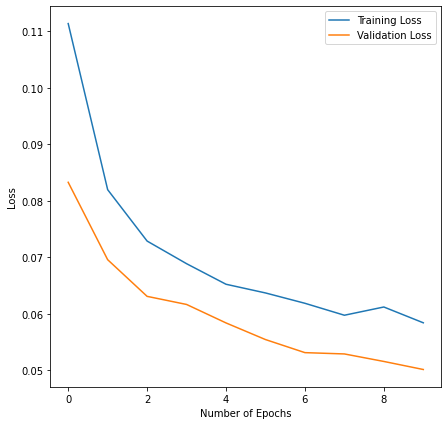

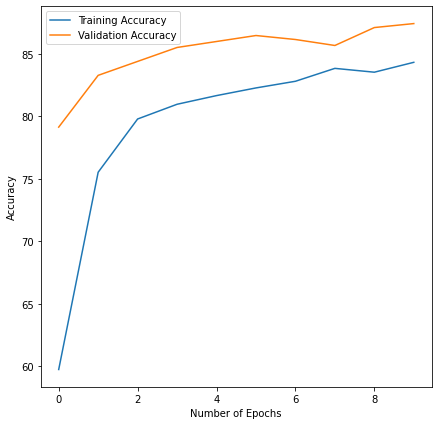

In [57]:
plotGraph(Epochs,trainingError,validationError, "Loss")
plotGraph(Epochs,trainingAccurcy,validationAccuracy, "Accuracy")

In [0]:
torch.save(resnetModelFocalLoss.state_dict(), 'gdrive/My Drive/MS-ITU-Smester-02/DL-05-part2/res18_focal_loss.pth')

In [92]:
resnet18.load_state_dict(torch.load('gdrive/My Drive/MS-ITU-Smester-02/DL-05-part2/res18_focal_loss.pth'))

<All keys matched successfully>

##### Training Accuracy and Confusion Matrix

In [113]:
actual , preds = getPrediction(resnet18,trainloader )
displayMeasures(actual , preds)

Accuracy of the network on the training images: 83 %
F1 score for covid-19 = 0.2893
Confusion matrix:
[[5993    7]
 [ 165   35]] 

F1 score for normal = 0.9159
Confusion matrix:
[[1856  344]
 [ 330 3670]] 

F1 score for pneumonia = 0.8127
Confusion matrix:
[[3801  399]
 [ 358 1642]] 



##### Validation Accuracy And Confusion Matrix

In [114]:
actual , preds = getPrediction(resnet18,validationloader )
displayMeasures(actual , preds)

Accuracy of the network on the training images: 85 %
F1 score for covid-19 = 0.2500
Confusion matrix:
[[600   0]
 [ 24   4]] 

F1 score for normal = 0.9164
Confusion matrix:
[[194  34]
 [ 33 367]] 

F1 score for pneumonia = 0.8790
Confusion matrix:
[[401  27]
 [ 22 178]] 



##### Testing Data CSV File Write For resnet18

In [0]:
preds = testAccuracy(resnet18,testloader)
preds = np.hstack((image_names, preds))

In [0]:
savetxt('gdrive/My Drive/MS-ITU-Smester-02/DL-05-part2/resnet18_FocalLocal_output.csv', preds, delimiter=',',fmt='%s')